# Audio Processing

In [4]:
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile as wav
from scipy.special import expit
import tensorflow as tf
import sqlalchemy as db
import sqlalchemy.orm as orm
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.dialects import postgresql

## File input

In [5]:
def wav_read(filename):
    """Return 1D NumPy array of wave-formatted audio data denoted by filename.
    
    Input should be a string containing the path to a wave-formatted audio file.
    File should be uncompressed 16-bit."""
    sample_rate, data_2d = wav.read(filename)
    data_1d = [val for val, _ in data_2d]
    return np.array(data_1d)

## Keystroke extraction

### Calculating Silence Threshold

In [3]:
def stats(array):
    """Return a dictionary containing relevant statistical data.
    
    :type array -- NumPy array
    :rtype dict
    """
    return {
        "length": len(array),
        "mean": np.mean(array),
        "median": np.median(array),
        "max": np.amax(array),
        "min": np.amin(array),
        "std deviation": np.std(array),
    }

#### Test 1 - Silence followed by 1 keystroke

length = 300000
mean = -0.46442333333333335
median = 0.0
max = 104
min = -104
std deviation = 22.414488044583774


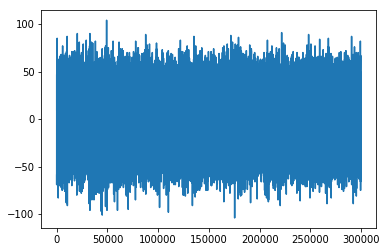

In [66]:
silence1_raw = wav_read('datasets/silence-threshold-tests/spacebar-1x-withsilence.wav')
silence1 = silence1_raw[:300000]

silence1_stats = stats(silence1)
for stat in silence1_stats:
    print(f'{stat} = {silence1_stats[stat]}')
    
plt.plot(silence1)
plt.show()

#### Test 2 - Silence followed by several keystrokes (same key, consistent pace)

length = 600000
mean = -0.46246
median = 0.0
max = 116
min = -121
std deviation = 24.353047531710143


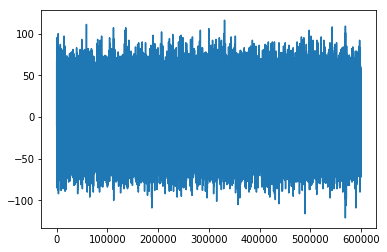

In [67]:
silence2_raw = wav_read('datasets/silence-threshold-tests/a-16x-withsilence.wav')
silence2 = silence2_raw[:600000]

silence2_stats = stats(silence2)
for stat in silence2_stats:
    print(f"{stat} = {silence2_stats[stat]}")
    
plt.plot(silence2)
plt.show()

#### Test 3 - Silence followed by several keystrokes (different keys, inconsistent pace)

length = 750000
mean = -0.47350933333333334
median = -1.0
max = 102
min = -101
std deviation = 20.25439809632909


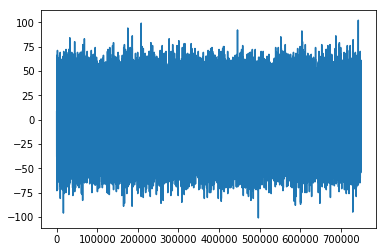

In [68]:
silence3_raw = wav_read('datasets/silence-threshold-tests/random-withsilence.wav')
silence3 = silence3_raw[:750000]

silence3_stats = stats(silence3)
for stat in silence3_stats:
    print(f'{stat} = {silence3_stats[stat]}')
plt.plot(silence3)
plt.show()

#### Test 4 - Silence followed by typing "hello "

length = 500000
mean = -0.476766
median = 0.0
max = 97
min = -96
std deviation = 19.28688591196733


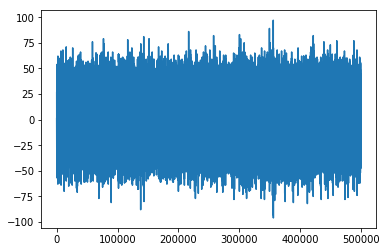

In [77]:
silence4_raw = wav_read('datasets/silence-threshold-tests/hello_.wav')
silence4 = silence4_raw[:500000]

silence4_stats = stats(silence4)
for stat in silence4_stats:
    print(f'{stat} = {silence4_stats[stat]}')
plt.plot(silence4)
plt.show()

#### Results

In [78]:
results = pd.DataFrame([silence1_stats, silence2_stats, silence3_stats, silence4_stats], 
                       index=['Test 1', 'Test 2', 'Test 3', 'Test 4'])
results

,length,max,mean,median,min,std deviation
Test 1,300000,104,-0.464423,0.0,-104,22.414488
Test 2,600000,116,-0.462460,0.0,-121,24.353048
Test 3,750000,102,-0.473509,-1.0,-101,20.254398
Test 4,500000,97,-0.476766,0.0,-96,19.286886


The recording software (GarageBand) samples wav values relative to the entire recording. For example, recording *just* silence results in large values during the silence compared to a recording of silence followed by a keystroke. Test 2 having a greater range and standard deviation can probably be attributed to the fact that the key pressed was "a", as opposed to the much louder "spacebar" and "random" in Tests 1 and 3. In Test 4, the microphone was placed on the table as opposed to near my mouth, which likely contributed to cleaner data.

### Sound preprocessing before keystroke extraction

In [4]:
def silence_threshold(sound_data, n):
    """Return the silence threshold of the sound data.
    The sound data should begin with n-seconds of silence.
    """
    sampling_rate = 44100
    num_samples   = sampling_rate * n
    silence       = sound_data[:num_samples]
    tolerance     = 40
    factor        = 11  # factor multiplied to threshold
    if np.std(silence) > tolerance:
        raise Exception(f'Sound data must begin with at least {n}s of silence.')
    else:
        return max(np.amax(silence), abs(np.amin(silence))) * factor

    
# This function might be unnecessary
def remove_random_noise(sound_data):
    """Remove random noise from sound data by replacing all values
    under the silence threshold to zero.
    """
    threshold = silence_threshold(sound_data, 5)
    sound_data_copy = sound_data[:]
    for i in range(len(sound_data_copy)):
        if abs(sound_data_copy[i]) < threshold:
            sound_data_copy[i] = 0
    return sound_data_copy

### Extracting individual keystrokes from an array of sound values

In [5]:
def extract_keystrokes(sound_data):
    """Return array of arrays denoting each keystroke detected in the sound_data.
    
    Each keystroke consists of a push peak (touch peak and hit peak) and a release peak.
    Returned keystrokes are coerced to be the same length by appending trailing zeros.
    
    :type sound_file  -- NumPy array denoting input sound clip
    :type sample_rate -- integer denoting sample rate (samples per second)
    :rtype            -- NumPy array of NumPy arrays
    """
    threshold          = silence_threshold(sound_data, 5)
    keystroke_duration = 0.3   # seconds (initial guess)
    sample_rate        = 44100 # Hz
    sample_length      = int(sample_rate * keystroke_duration)
    
    keystrokes = []
    i = 0
    while i < len(sound_data):
        if abs(sound_data[i]) > threshold:
            sample_start, sample_end = i, i + sample_length
            if sample_end <= len(sound_data) and abs(sound_data[sample_end]) > threshold:
                j = sample_end
                while sound_data[j] > threshold:
                    j -= 1
                sample_end = j
            keystroke = sound_data[sample_start:sample_end]
            trailing_zeros = np.array([0 for _ in range(sample_length - (sample_end - sample_start))])
            keystroke = np.concatenate((keystroke, trailing_zeros))
            keystrokes.append(keystroke)
            i = sample_end - 1
        i += 1
    return np.array(keystrokes)

#### Testing

In [6]:
def test_extract_keystrokes(data, expect):
    """Test if extract_keystrokes() extracts the correct number of keystrokes."""
    keystrokes = extract_keystrokes(data)
    actual = len(keystrokes)
    if expect == actual:
        print("Number of keystrokes matched!")
    else:
        print(f"Detected keystrokes mismatch. Found {actual} instead of {expect}.")
    
    
def run_extract_keystrokes_tests(test_set):
    base_dir = 'datasets/keystroke-extraction-tests/'
    for filename in test_set:
        wav_file = wav_read(base_dir + filename)
        expected = test_set[filename]
        test_extract_keystrokes(wav_file, expected)
        
        
test_set = {
    'hello_.wav': len('hello_'),
    'keyboard_.wav': len('keyboard_'),
    'password_.wav': len('password_'),
    'windsurfing_.wav': len('windsurfing_'),
    'zebra.wav': len('zebra'),
    'continental_drift_.wav': len('continental_drift_'),
    'jungle_cruise_.wav': len('jungle_cruise_'),
    'this_is_america.wav': len('this_is_america'),
}

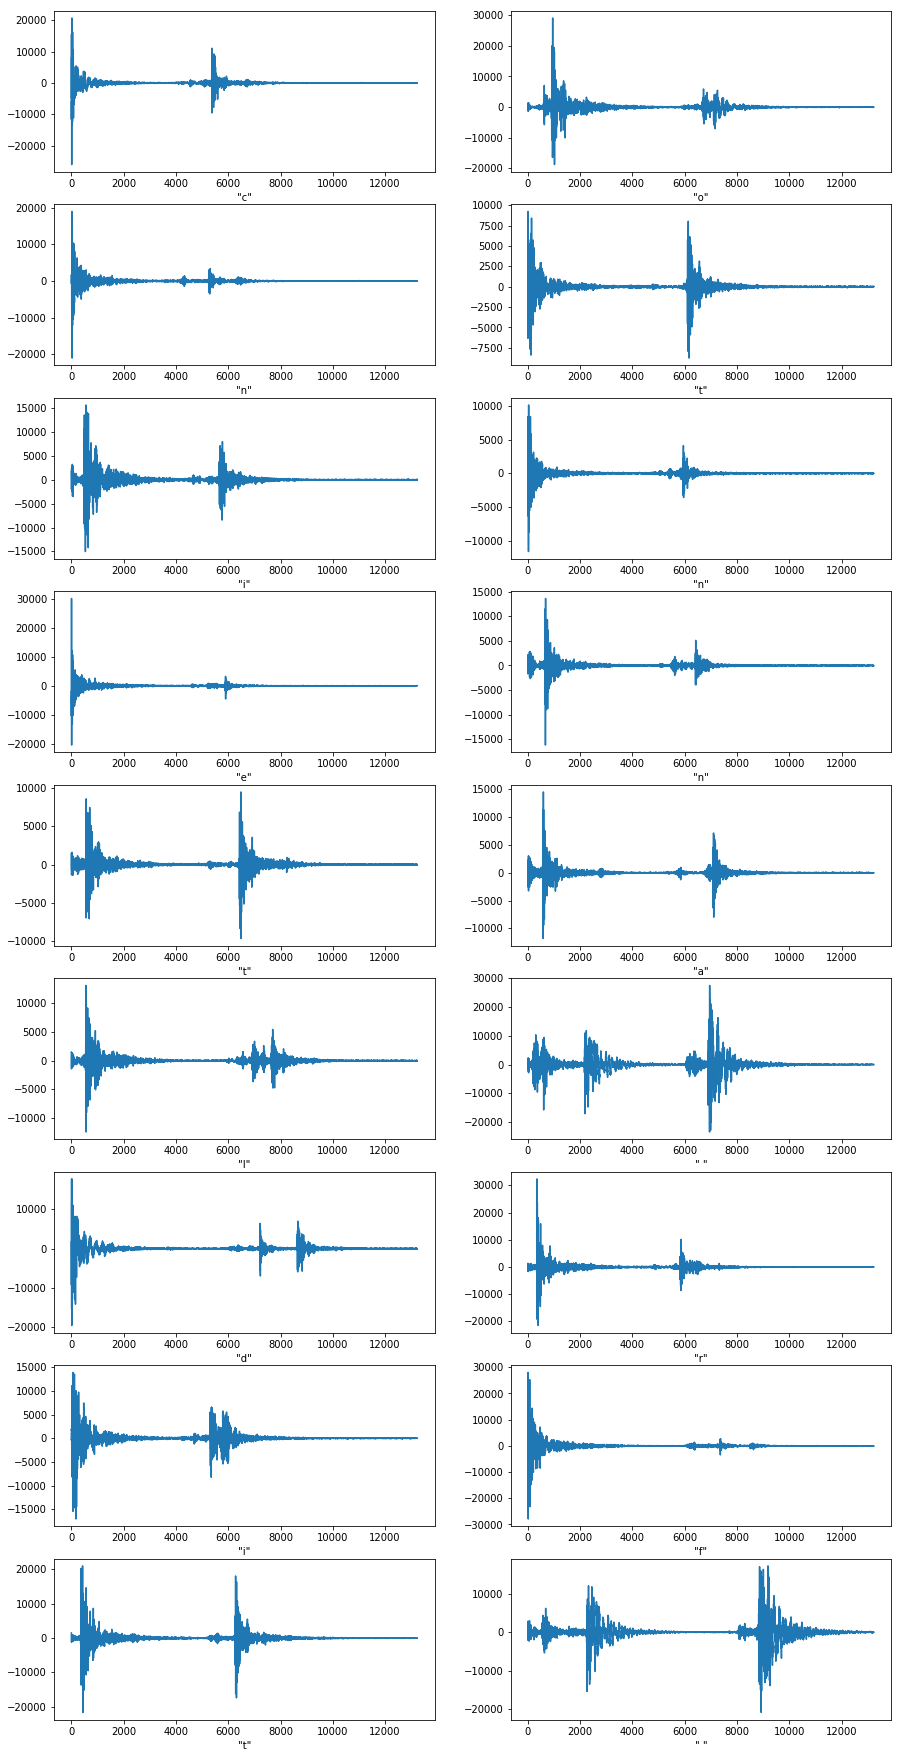

In [17]:
wav_data = wav_read('datasets/keystroke-extraction-tests/continental_drift_.wav')
keystrokes = extract_keystrokes(wav_data)

text = 'continental drift '
plt.figure(figsize=(15, 35))
n = len(keystrokes)
for i in range(n):
    plt.subplot(n / 2 + 1, 2, i + 1)
    plt.xlabel(f'"{text[i]}"')
    plt.plot(keystrokes[i])
plt.show()

## Collecting and (persistently) storing keystroke data

For future reference, I refer to the process of extracting keystroke data (as NumPy arrays) from raw WAV files as __collecting__ data. Collecting data is computationally expensive, and will become a bottleneck for productivity as the size of the datasets increases. Therefore, after collection, the extracted keystrokes will be stored in a Postgres database so that keystroke data can be retrieved without processing the WAV files again. I will refer to this process as __storing__ data, and the process of retrieval and other preprocessing (ex. scaling the data) as __loading__ data.

In [7]:
def collect_keystroke_data(output=False):
    """Read WAV files and return collected data.
    
    input format  -- WAV files in subdirectories of base_dir 
    output format -- list of dicts where each dict denotes a single collected
                     keystroke. Formatted like:
                         list(dict(keys: key type, sound digest, sound data))
    """
    base_dir = 'datasets/keystrokes/'
    alphabet = [letter for letter in 'abcdefghijklmnopqrstuvwxyz']
    other_keys = ['space', 'period', 'enter']
    keys = alphabet + other_keys
    
    collection = []
    for key in keys:
        wav_dir = base_dir + key + '/'
        if output: print(f'> Reading files from {wav_dir} for key "{key}"')
        for file in os.listdir(wav_dir):
            if output: print(f'  > Extracting keystrokes from "{file}"', end='')
            wav_data = wav_read(wav_dir + file)
            keystrokes = extract_keystrokes(wav_data)
            for keystroke in keystrokes:
                data = {
                    'key_type': key,
                    'sound_digest': hash(keystroke[:30].tobytes()),
                    'sound_data': keystroke,
                }
                collection.append(data)
            if output: print(f' => Found {len(keystrokes)} keystrokes')
    if output: print('> Done')
        
    return collection

### Schema

In [15]:
Base = declarative_base()


class Keystroke(Base):
    """Schema for Keystroke model."""
    __tablename__ = 'keystrokes'

    id = db.Column(db.BigInteger, primary_key=True)
    key_type = db.Column(db.String(32), nullable=False)
    sound_digest = db.Column(db.BigInteger, nullable=False, unique=True)
    sound_data = db.Column(postgresql.ARRAY(db.Float))

    def __repr__(self):
        return f'<Keystroke(key={self.key_type}, digest={self.sound_digest})>'

### Database manipulation utilities

In [16]:
def connect_to_database():
    """Connect to database and return engine, connection, metadata."""
    engine = db.create_engine(os.environ['DATABASE_URL'])
    connection = engine.connect()
    return engine


def create_keystroke_table():
    """Create keystroke table in database."""
    engine = connect_to_database()
    Base.metadata.create_all(engine)


def drop_keystroke_table():
    """Drop keystroke table in database."""
    engine = connect_to_database()
    Keystroke.__table__.drop(engine)

### Storing and Loading keystroke data

In [17]:
def store_keystroke_data(collected_data):
    """Store collected data in database and return result proxy.
    
    input format  -- output of collect_keystroke_data()
    """
    engine = connect_to_database()
    Session = orm.sessionmaker(bind=engine)
    session = Session()
    try:
        for data in collected_data:
            entry = Keystroke(key_type=data['key_type'],
                              sound_digest=data['sound_digest'],
                              sound_data=data['sound_data'])
            session.add(entry)
        session.commit()
    except:
        session.rollback()
        raise
    finally:
        session.close()

In [18]:
def load_keystroke_data():
    """Retrieve data from database, do relevant formatting, and return it.

    Return as a tuple of tuples of the form: (x, y)
    where x denotes training data and y denotes labels.

    This data will be passed to tf.keras.model.fit().
    For details, view documentation at: https://keras.io/models/model/#fit
    """
    engine = connect_to_database()
    Session = orm.sessionmaker(bind=engine)
    session = Session()
    keystrokes = session.query(Keystroke).all()
    session.close()

    data, labels = [], []
    for row in keystrokes:
        data.append(row.sound_data)
        labels.append(row.key_type)

    return np.array(data), np.array(labels)

### Data preprocessing

In [19]:
def scale_keystroke_data(data):
    """Scale each value in data to an appropriate value between 0 and 1.
    
    input format -- NumPy array of Numpy arrays
    """
    data_copy = deepcopy(data.astype(float))
    for i in range(len(data_copy)):
        data_copy[i] = expit(data_copy[i])
    return data_copy

## TensorFlow

### Hand-written digits

In [211]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

ex_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0, 2),
    tf.keras.layers.Dense(10, activation='softmax'),
])

ex_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
ex_model.fit(x_train, y_train, epochs=5)
ex_model.evaluate(x_test, y_test)

Epoch 1/5
60000/60000 [==============================] - 8s 131us/sample - loss: 0.2533 - accuracy: 0.9280
Epoch 2/5
60000/60000 [==============================] - 6s 104us/sample - loss: 0.1138 - accuracy: 0.9660
Epoch 3/5
60000/60000 [==============================] - 6s 105us/sample - loss: 0.0780 - accuracy: 0.9765
Epoch 4/5
60000/60000 [==============================] - 6s 104us/sample - loss: 0.0590 - accuracy: 0.9823
Epoch 5/5
10000/10000 [==============================] - 1s 59us/sample - loss: 0.0750 - accuracy: 0.9770


[0.07499508286234922, 0.977]

In [214]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

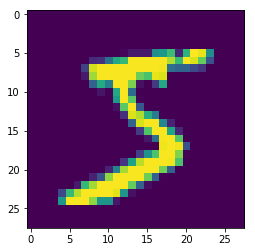

In [73]:
plt.figure()
plt.imshow(x_train[0])
plt.show()

## Application

In [ ]:
data, labels = load_keystroke_data()

In [12]:
data, labels

(array([[-662., -312., -145., ...,  -33.,  -24.,  -23.],
        [-651., -485., -307., ...,  -12.,    2.,   29.],
        [ 696.,   79.,  -93., ...,   -7.,   -4.,   -5.],
        ...,
        [-380., -224.,   18., ...,   -8.,  -13.,  -23.],
        [-331.,  -71.,  198., ...,    0.,    1.,   -3.],
        [ 341.,   80.,   47., ...,    0.,   -2.,    4.]]),
 array(['a', 'a', 'a', ..., 'enter', 'enter', 'enter'], dtype='<U6'))

In [13]:
scaled_data = scale_keystroke_data(data)

In [14]:
scaled_data

array([[3.14089183e-288, 3.16316354e-136, 1.06487866e-063, ...,
        4.65888615e-015, 3.77513454e-011, 1.02618796e-010],
       [1.88058203e-283, 2.32903640e-211, 4.69455094e-134, ...,
        6.14417460e-006, 8.80797078e-001, 1.00000000e+000],
       [1.00000000e+000, 1.00000000e+000, 4.07955867e-041, ...,
        9.11051194e-004, 1.79862100e-002, 6.69285092e-003],
       ...,
       [9.29173632e-166, 5.22439558e-098, 9.99999985e-001, ...,
        3.35350130e-004, 2.26032430e-006, 1.02618796e-010],
       [1.77225614e-144, 1.46248623e-031, 1.00000000e+000, ...,
        5.00000000e-001, 7.31058579e-001, 4.74258732e-002],
       [1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
        5.00000000e-001, 1.19202922e-001, 9.82013790e-001]])

In [5]:
key_data_scl = scale_keystroke_data(key_data)
x_train, y_train = load_keystroke_data(key_data_scl)

NameError: name 'key_data' is not defined

In [207]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(29, activation='softmax'),
])

In [209]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [1]:
model.fit(key_data_scl, epochs=5)

NameError: name 'model' is not defined